# <div align="center"><b> ПРОЕКТ №7. ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ </b></div> 

**Цель**: на основании исторических данных о поведении клиентов "Бета-банка" и расторжении договоров с банком требуется обучить модель, выполняющую прогноз: уйдет ли клиент в ближайшее время из банка или нет. Метрика F1 модели не должна быть менее 0.59.

# 1. Подготовка данных к обучению

## 1.1 Предобработка данных

С целью корректного обучения модели на этапе предобработки данных должно быть выполнено следующее:

- получение общей информации о данных, выявление возможных проблем;
- поиск и устранение аномальных значений и выбросов (при необходимости);
- поиск и устранение пропусков (при необходимости);
- поиск и устранение явных и неявных дубликатов;
- корректировка типов данных (при необходимости);

### 1.1.1 Импорт библиотек и исходных данных. Обзор данных <a id = 'overview'></a>

In [758]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from itertools import product

In [759]:
#снимем ограничение на количество столбцов датафрейма, выводимых на экран
pd.options.display.max_columns = None

In [760]:
#прочитаем файл с исходными данными, сохраним в переменную df
try:
    # local machine
    df = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_7\dataset\Churn.csv')
except:
    #yandex practicum server
#     код ревьюера
    df = pd.read_csv('/datasets/Churn.csv')
#     df_users = pd.read_csv('/datasets/users_behavior.csv')
    
#выведем на экран первые 5 строк датафрейма
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [761]:
#получим общую информацию о df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [762]:
#рассчитаем процент пропусков
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.090000
Balance,0.000000
NumOfProducts,0.000000


**Выводы по обзору датасета:**

- датасет содержит 10000 строк и 14 столбцов;
- в столбце *Tenure* пропущено 9% значений;
- заголовки столбцов приведены в стиле CamelCase;
- столбцы *RowNumber*, *CustomerId*, *Surname* не несут смысловой нагрузки в рамках обучения модели.


Для дальнейшей работы с датасетом необходимо:
- выполнить проверку значений на аномальные;
- выполнить поиск явных и неявных дубликатов;
- удалить столбцы *RowNumber*, *CustomerId*, *Surname*;
- обработать пропуски в *Tenure*;
- привести данные в столбцах *HasCrCard*, *IsActiveMember*, *Exited* к нужному типу;
- привести заголовки столбцов к стилю snake_case.

### 1.1.2 Приведениe заголовков столбцов к стилю snake_case

In [763]:
#заменим текущие названия столбцов списком с новыми названиями
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

#проверим результат
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### 1.1.3 Поиск аномальных значений и выбросов

Для поиска аномальных значений в столбцах с числовыми данными воспользуемся методом describe(), в столбцах с текстовыми данными - методом unique().

In [764]:
#получим статистическую информацию о числовых данных датафрейма
df.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [765]:
#получим статистическую информацию о текстовых данных датафрейма
df.describe(include='object')

,surname,geography,gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


Анализируя статистическую информацию о клиентах банка, можно сказать, что похожие на аномальные значения выявлены только в столбце `estimated_salary`. Судя по географии местоположения клиентов банка, ожидаемая зарплата приведена вдолларах или евро (далее - денежных единиц, д.е.). Минимальное значение ожидаемой заработной платы составляет 11.58 д.е., что может не соответствовать действительности - может быть, разделитель разрядов стоит не в том месте. 
Посмотрим, как распределены значения ожидаемой заработной платы:

In [766]:
#посчитаем, сколько значений попадает в интервал 100 д.е. при з/п от 0 до 1000 д.е.
df[df['estimated_salary']<=1000]['estimated_salary'].value_counts(bins=10).sort_index(ascending=True).reset_index()

,index,estimated_salary
0,"(10.596, 109.908]",5
1,"(109.908, 208.236]",4
2,"(208.236, 306.564]",4
3,"(306.564, 404.892]",3
4,"(404.892, 503.22]",8
5,"(503.22, 601.548]",7
6,"(601.548, 699.876]",6
7,"(699.876, 798.204]",7
8,"(798.204, 896.532]",7
9,"(896.532, 994.86]",8


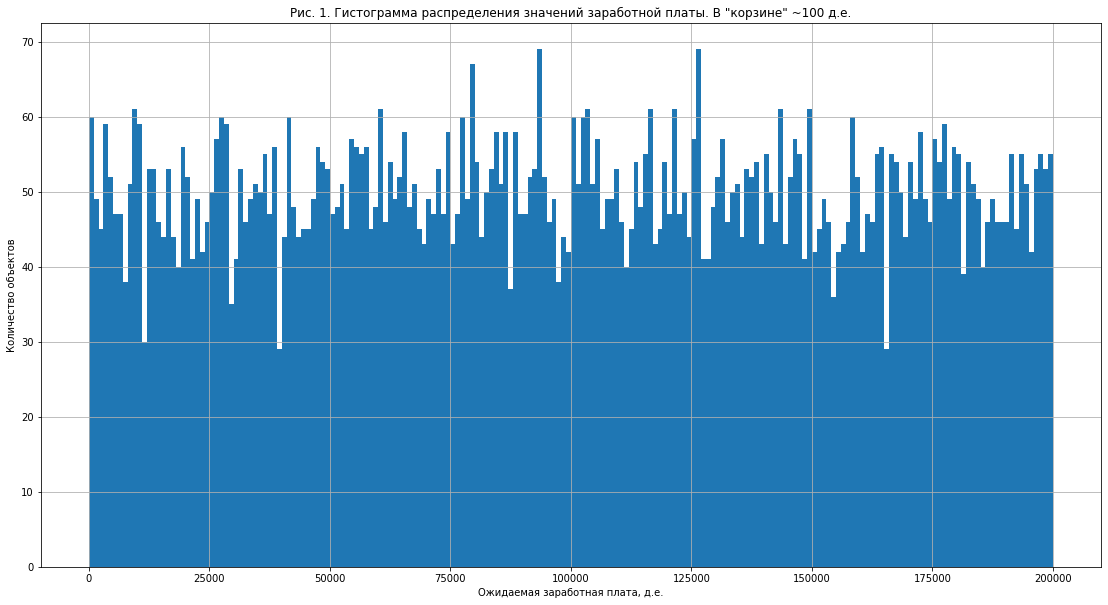

In [767]:
#построим гистрограмму распределения значений ожидаемой заработной платы
df['estimated_salary'].hist(bins=200, figsize=(19, 10))

#добавим элементы оформления гистограммы
plt.title('Рис. 1. Гистограмма распределения значений заработной платы. В "корзине" ~100 д.е.')
plt.xlabel('Ожидаемая заработная плата, д.е.')
plt.ylabel('Количество объектов');

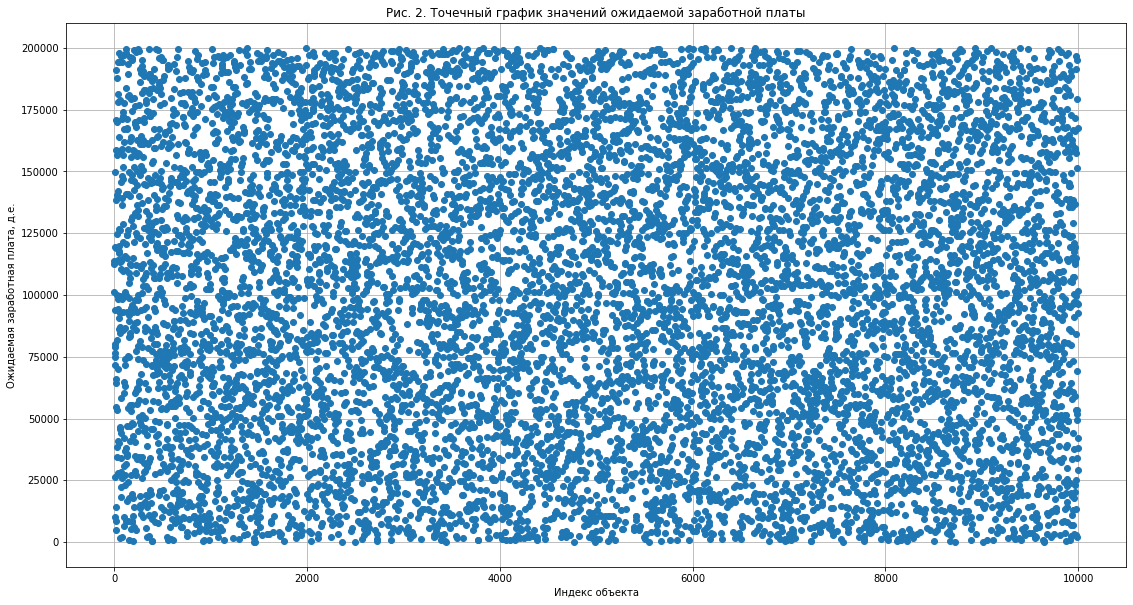

In [768]:
#построим точечный график значений ожидаемой заработной платы
df['estimated_salary'].plot(figsize=(19, 10), style='o', grid=True)

#добавим элементы оформления графика
plt.title('Рис. 2. Точечный график значений ожидаемой заработной платы')
plt.xlabel('Индекс объекта')
plt.ylabel('Ожидаемая заработная плата, д.е.');

На оснований гистограммы и точечного графика значений заработной платы можно сделать вывод о том, что встречаемости значений заработной платы относительно одинаковы и границы между "аномально маленькими" и нормальными значениями ожидаемой заработной платы также не выявлены, что говорит о том, что, скорее всего, аномальных значений в столбце `estimated_salary` нет.

Выполним поиск аномальных значений в текстовой информации - в столбцах `geography` и `gender`.

In [769]:
for col in ['geography', 'gender']:
    print('\nУникальные значения в столбце', col, ':')
    print(df[col].unique())


Уникальные значения в столбце geography :
['France' 'Spain' 'Germany']

Уникальные значения в столбце gender :
['Female' 'Male']


Аномальных значений, а также неявных дубликатов в столбцах `geography` и `gender` не выявлено.

Проверим данные на выбросы с помощью диаграммы размаха:

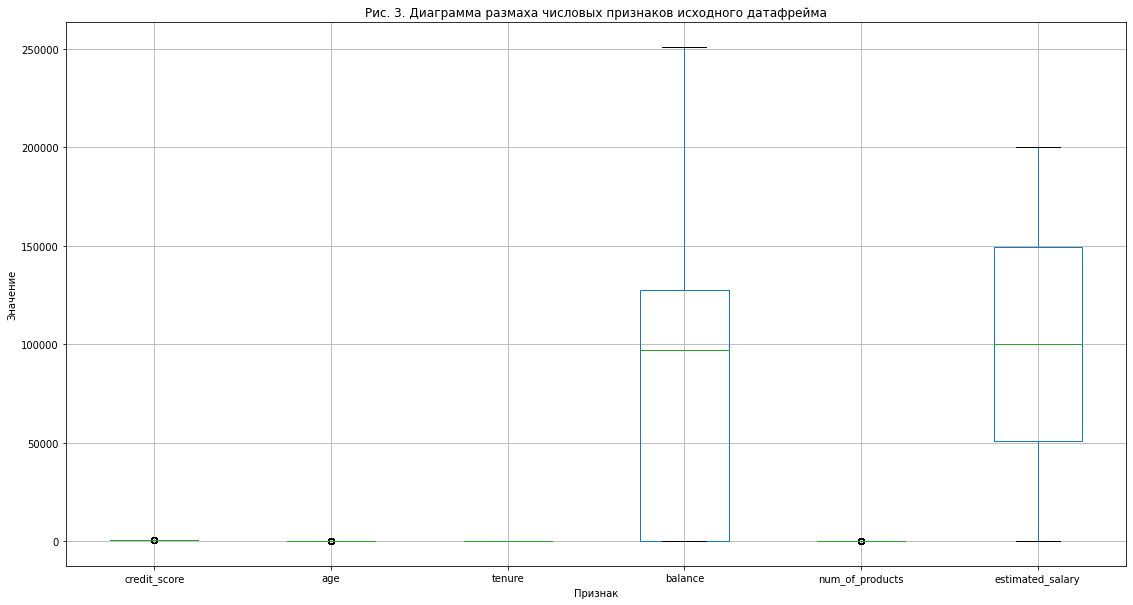

In [770]:
df[['credit_score',  'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']].boxplot(figsize=(19, 10))
plt.title('Рис. 3. Диаграмма размаха числовых признаков исходного датафрейма');
plt.xlabel('Признак');
plt.ylabel('Значение');

Выбросов в данных также не обнаружено.

### 1.1.4 Обработка пропусков

На этапе [обзора данных](#overview) было выявлено, что в столбце `tenure` пропущено 9% значений. Для корректного обучения модели пропуски нужно либо заполнить, либо удалить. Удалять пропуски нежелательно по двум причинам:
- значение пропущенных значений слишком велико;
- можно потерять важную для обучения информацию из остальных заполненных столбцов.

Так как клиенты разных возрастов и регионов проживания могут обладать разным пользовательским поведением, рассчитаем медианную продолжительность пользования услугами банка:
- для разных возрастов;
- для разных регионов

Если будут выявлены закономерности, используем их при заполнении пропусков, если нет - заполним медианным значением всего столбца.

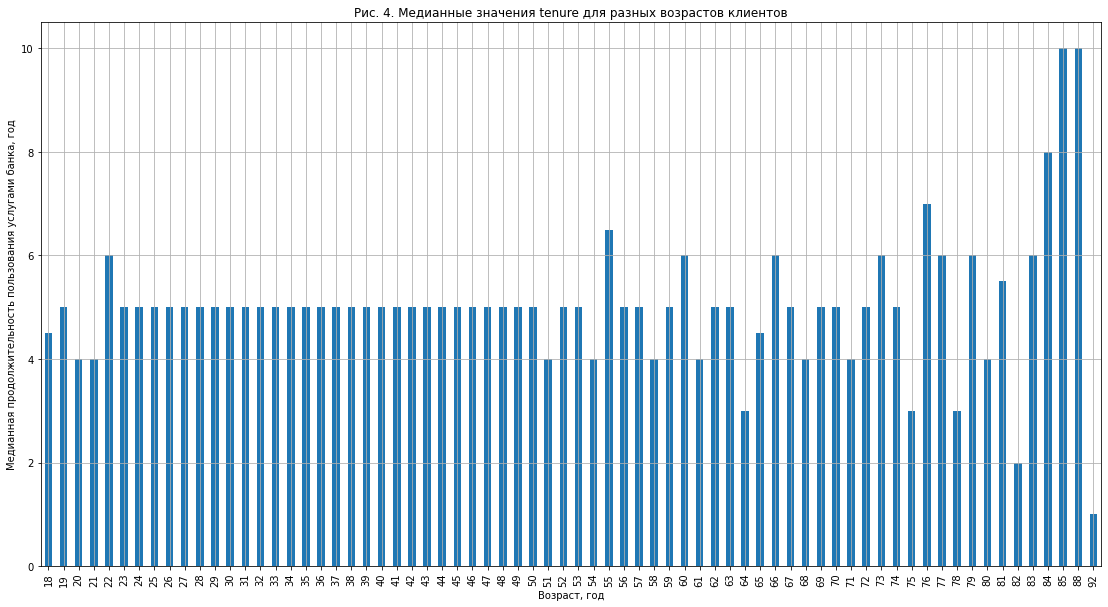

In [771]:
#построим график медианных значений tenure по уникальным значениям age
df.groupby(by='age')['tenure'].median().plot(kind='bar', figsize=(19, 10), grid=True)

#добавим элементы оформления графика
plt.title('Рис. 4. Медианные значения tenure для разных возрастов клиентов')
plt.xlabel('Возраст, год')
plt.ylabel('Медианная продолжительность пользования услугами банка, год');

In [772]:
#рассчитаем медианные значения tenure по регионам
df.groupby(by='geography')['tenure'].median().reset_index()

,geography,tenure
0,France,5.0
1,Germany,5.0
2,Spain,5.0


Для подавляющего большинства возрастов и для всех регионов медианное значение `tenure` составляет 5 лет. Для клиентов возрастом 84-85 лет медианная продолжительность пользования услугами банка превышает 5 лет, при этом для возраста 85 и 88 лет медианная стоимость максимальная (10 лет) и равна максимальному сроку пользования услугами банка.

Заполним пропуски медианным значением `tenure` по каждому возрасту:

In [773]:
#составим список возрастов
lst_of_ages = df['age'].unique()
lst_of_ages

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83])

In [774]:
#заменим пропуски в столбце tenure медианным значением tenure для каждого возраста
for age in lst_of_ages:
    df.loc[(df['tenure'].isna())&(df['age']==age), 'tenure'] = df[df['age']==age]['tenure'].median()
    
#проверим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


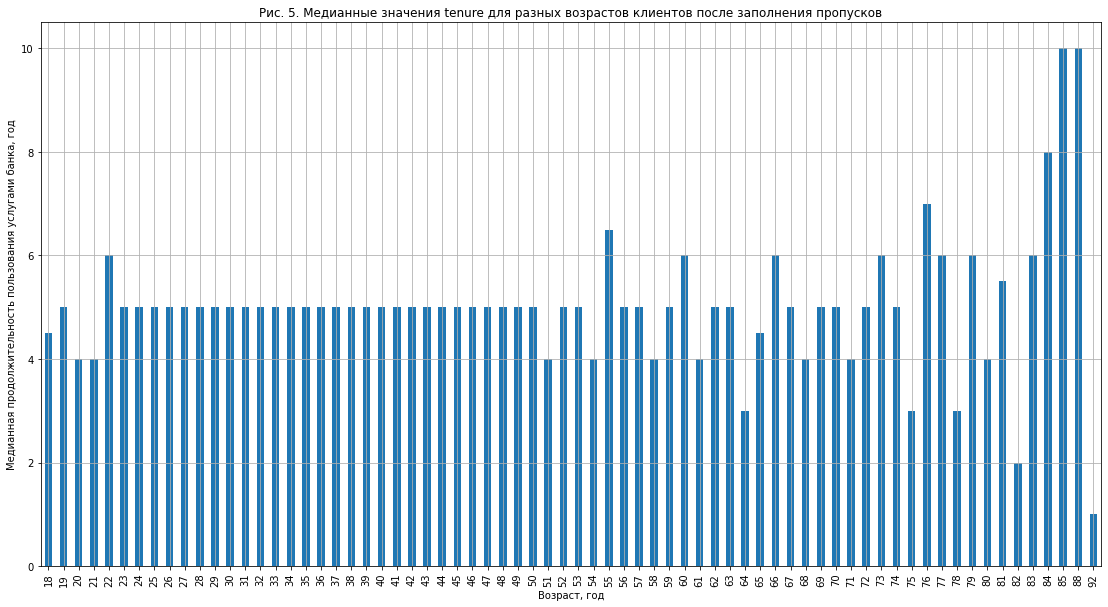

In [775]:
#построим диаграмму медианных значений tenure по возрастам после заполнения пропусков
df.groupby(by='age')['tenure'].median().plot(kind='bar', figsize=(19, 10), grid=True)

#добавим элементы оформления графика
plt.title('Рис. 5. Медианные значения tenure для разных возрастов клиентов после заполнения пропусков')
plt.xlabel('Возраст, год')
plt.ylabel('Медианная продолжительность пользования услугами банка, год');

Диаграмма не изменилась, заполнение пропусков выполнено корректно.
Изменим тип столбца `tenure` на integer.

In [776]:
df['tenure'] = df['tenure'].astype('int')

#проверим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Тип данных столбца `tenure` успешно изменен.

### 1.1.5 Поиск дубликатов

Проверим датасет на наличие полных дубликатов:

In [777]:
df.duplicated().sum()

0

Полных дубликатов нет. Неявные дубликаты могут скрываться в столбцах `geography` и `gender`, однако на этапе поиска аномальных значений было выявлено, что неявные дубликаты в этих столбцах отсутствуют.

Кроме явных и неявных дубликатов, может существовать ситуация, когда разным пользователям, вследствие какой-либо ошибки, присвоен одинаковый customer_id. Проверим:

In [778]:
#посчитаем количество уникальных значений в customer_id
df['customer_id'].nunique()

10000

Количество уникальных значений соответствет количеству строк в датафрейме, следовательно, разным пользователям один customer_id не назначен. Проверим, назначены ли разные customer_id одному пользователю:

In [779]:
df.loc[:, ['surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']].duplicated().sum()

0

Исключим из поиска дубликатов столбец `surname`:

In [780]:
df.loc[:, ['credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']].duplicated().sum()

0

Пользователей с разными customer_id также не обнаружено.

<font color="green">✔️ Комментарий ревьювера   
Все верно</font>


### 1.1.6 Удаление столбцов

В рамках создания модели по прогнозированию оттока клиентов столбцы `row_number`, `customer_id` и `surname` не несут практической ценности и могут усложнить обучение модели. Удалим их из датасета.

In [781]:
#удалим лишние столбцы
df=df.drop(['row_number', 'customer_id', 'surname'], axis=1)

#проверим результат
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

<font color="green">✔️ Комментарий ревьювера   
Все верно</font>


Лишние столбцы удалены.

## 2. Кодирование признаков

В исходном датасете приведено два типа категориальных переменных: пол и страна проживания. Закодируем столбцы `gender` и `geography` с помощью прямого кодирования.

In [782]:
#закодируем данные о стране проживания и гендере
df=pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)

In [783]:
#проверим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [784]:
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Кодирование категориальных признаков выполнено.

## 3. Разбиение исходных данных на обучающую, валидационную и тестовую выборку <a id='3'></a>

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Выполним это в два этапа:

- выделим обучающую выборку и совместную выборку для валидации и тестирования;
- разделим совместную выборку для валидации и тестирования на валидационную и тестовую.

После завершения разбивки для каждой выборки выделим набор признаков, а также целевой признак.

Перед разделением выборки определим, какой процент выборки занимают оставшиеся и ушедшие клиенты соответственно:

In [785]:
df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Количество клиентов, покинувших банк, практически в 4 раза меньше, чем действующих клиентов банка. Классы несбалансированы.

**Разделим исходные данные на обучающую и совместную выборку для валидации и тестирования:**

In [786]:
df_train, df_valid_and_test = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['exited'])

In [787]:
#определим процент классов в выборке df_train
df_train['exited'].value_counts(normalize=True)

0    0.796333
1    0.203667
Name: exited, dtype: float64

In [788]:
#определим процент классов в выборке df_valid_and_test
df_valid_and_test['exited'].value_counts(normalize=True)

0    0.79625
1    0.20375
Name: exited, dtype: float64

**Разделим совместную выборку для валидации и тестирования на валидационную и тестовую:**

In [789]:
df_valid, df_test = train_test_split(df_valid_and_test, test_size=0.5, random_state=12345, stratify=df_valid_and_test['exited'])

In [790]:
#определим процент классов в выборке df_valid
df_valid['exited'].value_counts(normalize=True)

0    0.796
1    0.204
Name: exited, dtype: float64

In [791]:
#определим процент классов в выборке df_test
df_test['exited'].value_counts(normalize=True)

0    0.7965
1    0.2035
Name: exited, dtype: float64

Проверим размерности обучающей, валидационной и тестовой выборок:

In [792]:
print('Размер обучающей выборки:', df_train.shape)
print('Размер валидационной выборки:', df_valid.shape)
print('Размер тестовой выборки:', df_test.shape)

Размер обучающей выборки: (6000, 12)
Размер валидационной выборки: (2000, 12)
Размер тестовой выборки: (2000, 12)


Процент каждого класса в обучающей, валидационной и тестовой выборках соответствует исходной выборке. Соотношение размера обучающей, валидационной и тестовой выборок составляет 3:1:1. Разделение выполнено корректно.

**Выделим в обучающей, валидационной и тестовой выборках признаки (features) и целевой признак (target):**

In [793]:
#разделим обучающую выборку на features и target
features_train = df_train.drop('exited', axis=1)
target_train = df_train['exited']

#проверим размер полученных выборок
print('Размер features_train:', features_train.shape)
print('Размер target_train:', target_train.shape)

Размер features_train: (6000, 11)
Размер target_train: (6000,)


In [794]:
#разделим валидационную выборку на features и target
features_valid = df_valid.drop('exited', axis=1)
target_valid = df_valid['exited']

#проверим размер полученных выборок
print('Размер features_valid:', features_valid.shape)
print('Размер target_valid:', target_valid.shape)

Размер features_valid: (2000, 11)
Размер target_valid: (2000,)


In [795]:
#разделим тестовую выборку на features и target
features_test = df_test.drop('exited', axis=1)
target_test = df_test['exited']

#проверим размер полученных выборок
print('Размер features_test:', features_test.shape)
print('Размер target_test:', target_test.shape)

Размер features_test: (2000, 11)
Размер target_test: (2000,)


Признаки и целевой признак выделены корректно.

<font color="green">✔️ Комментарий ревьювера   
Все верно</font>


## 4. Стандартизация признаков

В выборке присутствуют численные признаки разного масштаба: возраст (`age`), кредитный рейтинг (`credit_score`), ожидаемая заработная плата (`estimated_salary`) и т. д. Для корректного обучения модели необходимо стандартизировать признаки.

In [796]:
#выделим столбцы для стандартизации
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

#создадим и настроим StandardScaler
scaler = StandardScaler()
scaler.fit(features_train[numeric])

#стандартизируем признаки в features_train
features_train[numeric] = scaler.transform(features_train[numeric])

In [797]:
#проверим результат
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.361185,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-0.001937,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.087427,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-0.001937,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.454422,0.879129,-0.914708,1,0,0.113236,0,0,0


После стандартизации среднее значение преобразованных признаков М = 0, дисперсия D = 1. Проверим.

In [798]:
#рассчитаем среднее значение преобразованных признаков
np.mean(features_train[numeric])

credit_score        5.844214e-16
age                -6.987004e-17
tenure             -1.274536e-16
balance             1.427007e-16
num_of_products     1.338189e-16
estimated_salary   -7.993606e-17
dtype: float64

In [799]:
#рассчитаем дисперсии преобразованных признаков
np.var(features_train[numeric])

credit_score        1.0
age                 1.0
tenure              1.0
balance             1.0
num_of_products     1.0
estimated_salary    1.0
dtype: float64

Дисперсия D=1, средние значения близки к 0.

In [800]:
#стандартизируем признаки в features_valid
features_valid[numeric] = scaler.transform(features_valid[numeric])

#стандартизируем признаки в features_test
features_test[numeric] = scaler.transform(features_test[numeric])

Рассчитаем дисперсии и средние значения признаков в валидационной и тестовой выборках после стандартизации.

In [801]:
np.mean(features_valid[numeric])

credit_score        0.041401
age                -0.001779
tenure              0.007323
balance            -0.000113
num_of_products     0.023432
estimated_salary   -0.039254
dtype: float64

In [802]:
np.var(features_valid[numeric])

credit_score        0.970954
age                 1.000354
tenure              1.012774
balance             0.970508
num_of_products     1.040436
estimated_salary    0.990768
dtype: float64

In [803]:
np.mean(features_test[numeric])

credit_score       -0.011548
age                -0.035095
tenure             -0.026266
balance             0.011621
num_of_products     0.004339
estimated_salary    0.011986
dtype: float64

In [804]:
np.var(features_test[numeric])

credit_score        0.988506
age                 0.995499
tenure              1.014971
balance             0.997840
num_of_products     1.054806
estimated_salary    1.003447
dtype: float64

Средние значения и дисперсии стандартизированных признаков в валидационной и тестовой выборках близки к 0 и 1 соответственно, однако погрешности больше, чем после стандартизации обучающей выборки. Это может быть объяснено тем, что scaler настраивался только по обучающей выборке.

# 3. Обучение модели без учета дисбаланса классов

В текущем разделе создадим модель прогнозирования оттока клиентов без учета дисбаланса классов. Рассмотрим модели на базе алгоритмов логистической регрессии, дерева решений и случайного леса, подберем наилучшие гиперпараметры.

## 3.1 Обучение модели на основе алгоритма случайного леса.

Создадим стуктуру для хранения информации о моделях и полученной точности:

In [805]:
final_table = {'model_name':[], 'algotyrhm':[], 'balance':[], 'f1':[], 'auc-roc':[]}

Напишем функцию,осуществляющую прогноз, а также расчет значения метрик f1 и AUC-ROC: <a id='predict_and_f1'></a>

In [806]:
def predict_and_f1(model_name, features, target):
    
    #рассчитаем значение f1
    predictions = model_name.predict(features)
    f1 = f1_score(target, predictions)
    
    #рассчитаем значение auc_roc
    probabilities = model_name.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one)
    
    #вернем значения метрик f1 и auc-roc
    return f1, auc_roc

Напишем функцию, сохраняющую значения метрик выбранной модели в final_table и выводящую на печать результат: параметры модели и значения метрик f1 и auc-roc.<a id='fill_final_table'></a>

In [807]:
#model_name - имя модели, object
#algorythm - алгоритм обучения, object
#balance - способ борьбы с дисбалансом, object
#f1, auc_roc - значения одноименных метрик, float

def fill_final_table(model_name, algorythm, balance, f1, auc_roc):
    
    #округлим значения метрик до 3 знаков после запятой
    f1 = round(f1, 3) 
    auc_roc = round(auc_roc, 3)  
    
    #создадим список с характеристиками модели и сохраним его в final_table
    lst_of_model_params = [model_name, algorythm, balance, f1, auc_roc]
    for i, key in enumerate(final_table):
        final_table[key].append(lst_of_model_params[i])
    
    #отобразим гиперпараметры модели, f1, auc-roc
    print('f1', f1)
    print('auc_roc', auc_roc)
    print('Наилучшие параметры:', eval(model_name))    
        
    return

Обучим модель на основе алгоритма случайного леса со значениями по умолчанию:

In [808]:
%%time

#создадим и обучим модель
start_rf_model = RandomForestClassifier(random_state=12345)
start_rf_model.fit(features_train, target_train)

#сделаем прогноз целевого признака по валидационной выборке и рассчитаем его точность, а также значение f1-меры 
f1, auc_roc = predict_and_f1(start_rf_model, features_valid, target_valid)

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('start_rf_model', 'RandomForest', 'No', f1, auc_roc)

f1 0.596
auc_roc 0.858
Наилучшие параметры: RandomForestClassifier(random_state=12345)
CPU times: user 702 ms, sys: 20 ms, total: 722 ms
Wall time: 724 ms


Значение f1-меры соответствует требуемому - не менее 0.59 (*модель готова, расходимся? :))* )
Проверим, можно ли улучшить модель за счет подбора гиперпараметров, других алгоритмов (линейной регрессии) и учета дисбаланса классов.

Для уменьшения количества кода напишем функцию, которая с помощью цикла подбирает наилучшие гиперпараметры, а также сохраняет рассмотренные гиперпараметры и соответствующие им значения метрик f1 и auc-roc.<a id='training'></a>

In [809]:
#входные параметры: обучающая выборка, обучающий целевой признак, валидационная выборка, валидационный целевой признак, гиперпараметры, алгоритм обучения
#гиперпараметры должны храниться в словаре, где ключ - наименование гиперпараметра
#предусмотрены следующие алгоритмы обучения: 'rf' (RandomForrest), 'dt' (DecisionTree), 'lr' (LogisticRegression)

def training(features_train, target_train, features_valid, target_valid, parameters, algorythm):

    #проверим, правильно ли указано название алгоритма классификации
    if algorythm not in ['rf', 'dt', 'lr']:
        display('Укажите алгоритм: "rf" (RandomForrest), "dt" (DecisionTree), "lr" (LogisticRegression)')
        return 
    
    #зададим начальные значения параметров
    best_model = None
    best_params = None
    best_f_1 = 0
    auc_roc_of_best_f_1 = 0 
    
    #получим наименования гиперпараметров
    list_of_params = list(parameters.keys())
    
    #создадим структуру для хранения комбинаций параметров и соответствующих значений метрик
    metrics_for_plot = {}
    for parameter in list_of_params:
        metrics_for_plot[parameter]=[]
        metrics_for_plot['f1']=[]    
        metrics_for_plot['auc_roc']=[]      
    
    #сформируем комбинации гиперпараметров, соединим каждый гиперпараметр со своим названием
    for par in product(*parameters.values()):
        komb_of_par = dict(zip(list_of_params, list(par)))
        
        #выберем нужный алгоритм классификации и создадим модель
        if algorythm == 'rf':
            model = RandomForestClassifier(random_state=12345, **komb_of_par)
        elif algorythm == 'dt':
            model = DecisionTreeClassifier(random_state=12345, **komb_of_par)
        elif algorythm == 'lr':
            model = LogisticRegression(random_state=12345, **komb_of_par)
        
        #обучим модель на тренировочной выборке
        model.fit(features_train, target_train)
        
        #сделаем прогно целевого признака по валидационной выборке и рассчитаем его точность, а также значение f1-меры 
        f1, auc_roc = predict_and_f1(model, features_valid, target_valid)
                
        #запишем текущие значения гиперпараметров для построения графиков
        for j in komb_of_par.keys():
            metrics_for_plot[j].append(komb_of_par[j])
        
        #запишем значения метрик f1 и auc-roc, соответствующие текущему набору гиперпараметро
        metrics_for_plot['f1'].append(f1)    
        metrics_for_plot['auc_roc'].append(auc_roc)              
            
        #сравним точность текущей модели с предыдущим значением. При успехе примем модель за наилучшую
        if f1 > best_f_1:
            best_model = model
            auc_roc_of_best_f_1 = auc_roc
            best_f_1 = f1
            #best_params = komb_of_par
  
    
    #вернем в результате работы функции лучшую модель, значения метрик f1, auc-roc, наилучшее сочетание гиперпараметров и информацию о
    #всех рассмотренных гиперпараметрах и соответствующих им значенияях метрик f1 и auc-roc
    return best_model, best_f_1, auc_roc_of_best_f_1, metrics_for_plot

Напишем функцию, принимающую рассмотренные комбинации гиперпараметров и соответствующие им значения f1 и auc-roc и осуществляющую построение графиков значений метрик.<a id='plot_graphs'></a>

In [810]:
def plot_graphs(metrics_info, pictures_number, algorythm, balance, index_my, columns_my):
    #преобразуем metrics_info в датафрейм
    metrics_info = pd.DataFrame(metrics_info)
    display(metrics_info)
    
    #построим график изменения значения метрики f1 и auc_roc в зависимости от максимальной глубины и количества деревьев
    for metr in ['f1', 'auc_roc']:
        
        #сгруппируем данные и построим график
        metrics_info.pivot_table(index=index_my, columns=columns_my, values=metr).plot(figsize=(19,10), grid=True)
        
        #добавим элементы оформления графика
        plt.title('Рис.'+str(pictures_number+['f1', 'auc_roc'].index(metr))+'. График зависимости '+metr+' от '+str(index_my)
                 +', '+str(columns_my)+'. Баланс: ' + balance+'. Алгоритм: '+algorythm) 
        plt.ylabel('Значение метрики ' + metr);
      
    return 

Используя функцию *training()* попробуем улучшить модель за счет подбора гиперпараметров.

In [811]:
#сформируем словарь с гиперпараметрами
parameters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [812]:
#найдем наилучшую модель и выведем результаты на экран
best_rf_2, f1, auc_roc, metrics = training(features_train, target_train, features_valid, target_valid, parameters, 'rf')

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_rf_2', 'RandomForest', 'No', f1, auc_roc)

f1 0.62
auc_roc 0.865
Наилучшие параметры: RandomForestClassifier(max_depth=14, n_estimators=30, random_state=12345)


,n_estimators,f1,auc_roc,max_depth
0,10,0.000000,0.780805,1
1,10,0.227957,0.817196,2
2,10,0.253165,0.836955,3
3,10,0.525790,0.849040,4
4,10,0.547504,0.859782,5
...,...,...,...,...
145,100,0.603030,0.871125,11
146,100,0.601796,0.871364,12
147,100,0.586989,0.865544,13
148,100,0.602086,0.867337,14


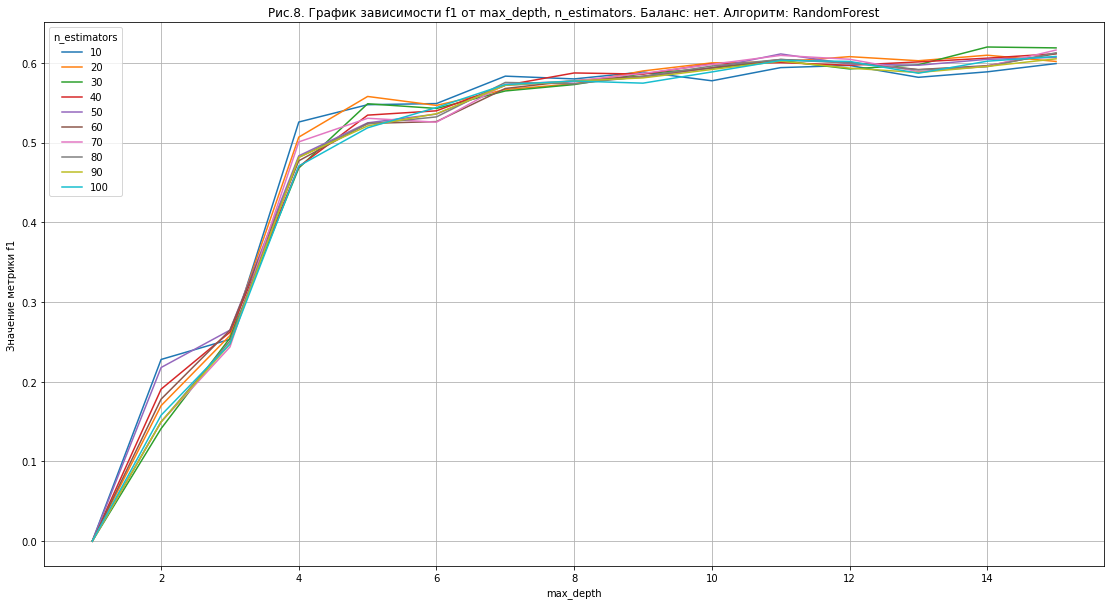

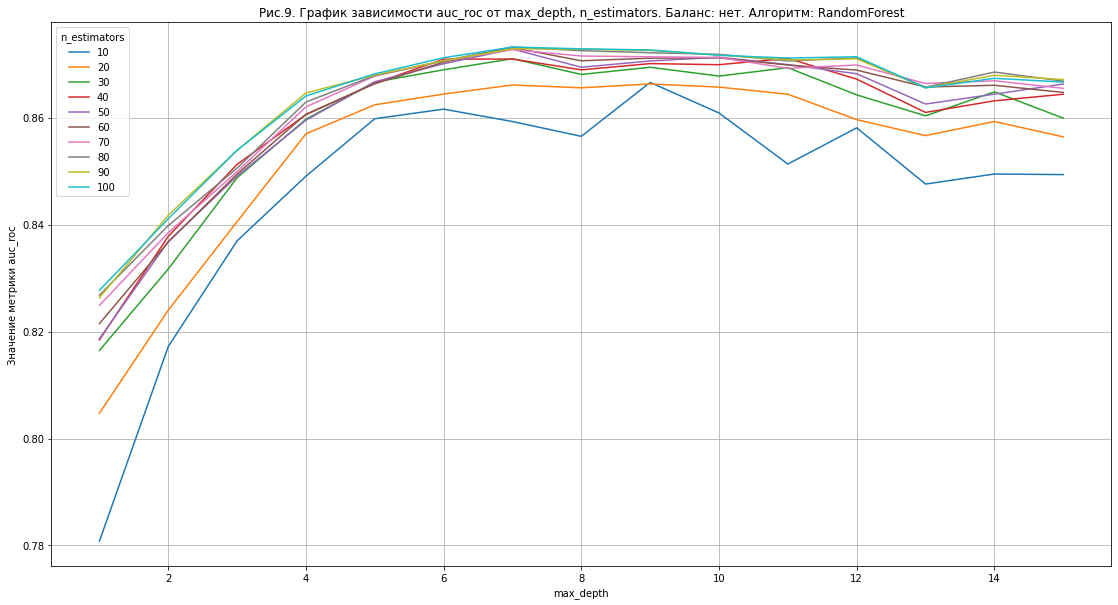

In [813]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 8, 'RandomForest', 'нет', 'max_depth', 'n_estimators')

Благодаря подбору гиперпараметров модель прогноза оттока клиентов на базе алгоритма случайного леса удалось улучшить до значения метрики F1 = 0.62. Значение метрики AUC-ROC снизилось незначительно (на 0.003) и  составляет 0.865. Наилучшее количество деревьев в модели: 30, наилучшая максимальная глубина дерева: 14.

## 3.2 Обучение модели на основе алгоритма логистической регрессии

Обучим модель на основе алгоритма логистической регрессии со значениями по умолчанию.

In [814]:
%%time

#создадим и обучим модель
start_lr_model = LogisticRegression(random_state=12345)
start_lr_model.fit(features_train, target_train)

#сделаем предсказание и оценим его точность
f1, auc_roc = predict_and_f1(start_lr_model, features_valid, target_valid)

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('start_lr_model', 'LinearRegression', 'No', f1, auc_roc)

f1 0.308
auc_roc 0.788
Наилучшие параметры: LogisticRegression(random_state=12345)
CPU times: user 117 ms, sys: 162 ms, total: 279 ms
Wall time: 209 ms


Модель на основе логистической регрессии учится быстрее, чем случайный лес, однако результат хуже. Попробуем подобрать гиперпараметры.

In [815]:
#сформируем словарь с гиперпараметрами
parameters = {'max_iter':[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}

In [816]:
#найдем наилучшую модель и выведем результаты на экран
best_lr_2, f1, auc_roc, metrics = training(features_train, target_train, features_valid, target_valid, parameters, 'lr')

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_lr_2', 'LogisticRegression', 'No', f1, auc_roc)

f1 0.308
auc_roc 0.788
Наилучшие параметры: LogisticRegression(random_state=12345)


,max_iter,f1,auc_roc
0,100,0.307692,0.787511
1,110,0.307692,0.787511
2,120,0.307692,0.787511
3,130,0.307692,0.787511
4,140,0.307692,0.787511
5,150,0.307692,0.787511
6,160,0.307692,0.787511
7,170,0.307692,0.787511
8,180,0.307692,0.787511
9,190,0.307692,0.787511


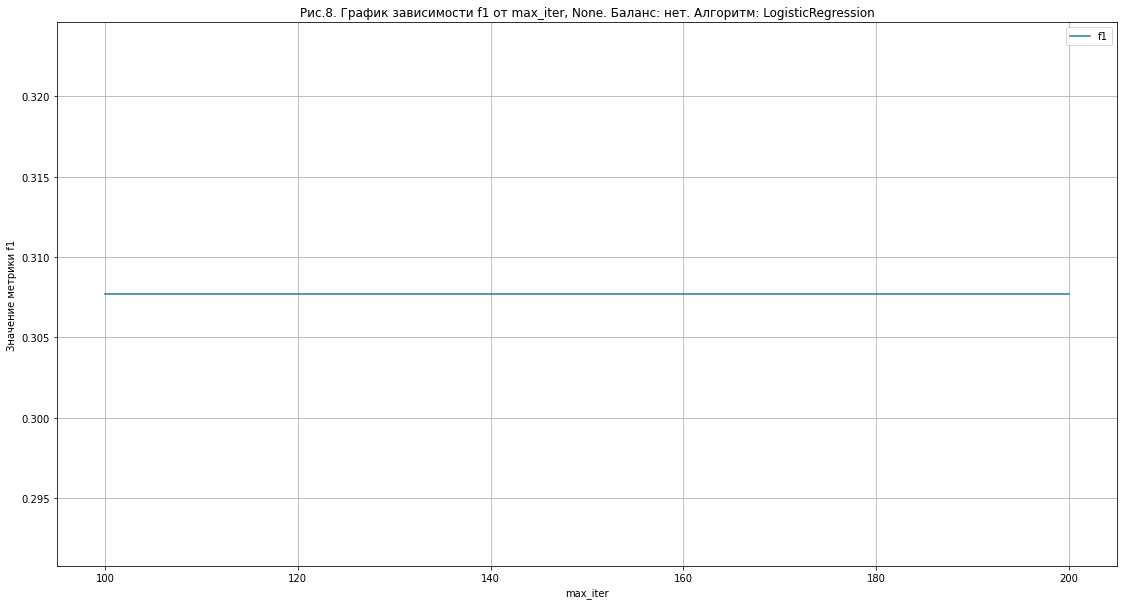

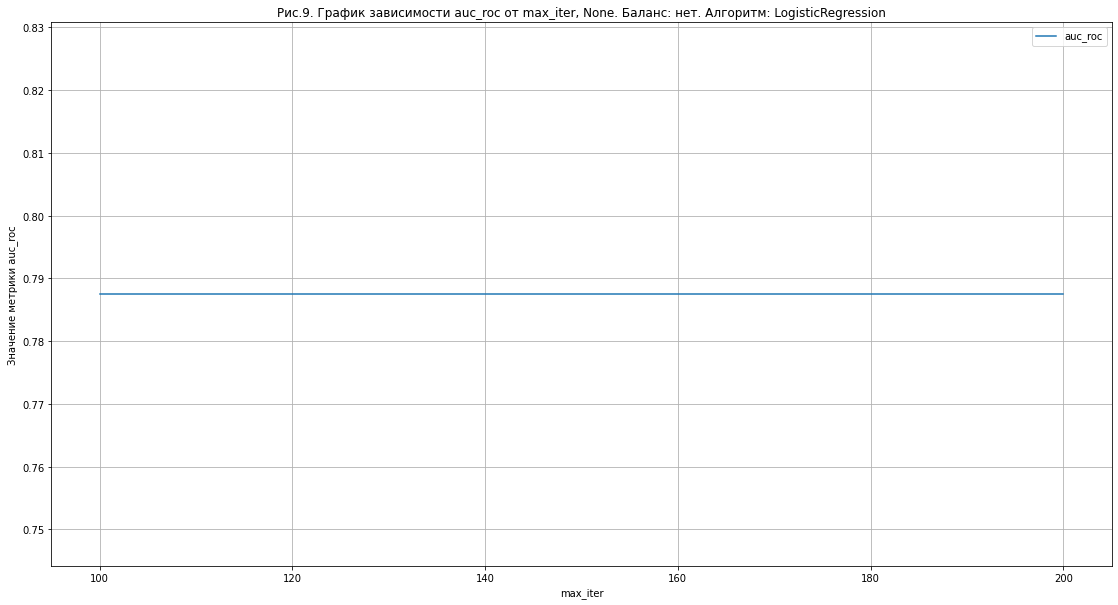

In [817]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 8, 'LogisticRegression', 'нет', 'max_iter', None)

Изменение максимального количества итераций не влияет на результат обучения модели на базе логистической регрессии. Значение f1 меры на несбалансированном датасете постоянно и не превышает значения 0.31. Значение AUC-ROC также постоянно и не превышает 0.79.

Обучим модель на базе алгорима дерева решений.

## 3.3 Обучение модели на основе алгоритма дерева решений

Обучим модель на основе алгоритма логистической регрессии со значениями по умолчанию.

In [818]:
%%time

#создадим и обучим модель
start_dt_model = DecisionTreeClassifier(random_state=12345)
start_dt_model.fit(features_train, target_train)

#сделаем предсказание и оценим его точность
f1, auc_roc = predict_and_f1(start_dt_model, features_valid, target_valid)

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('start_dt_model', 'DecisionTree', 'No', f1, auc_roc)

f1 0.515
auc_roc 0.697
Наилучшие параметры: DecisionTreeClassifier(random_state=12345)
CPU times: user 35.9 ms, sys: 202 µs, total: 36.1 ms
Wall time: 34.5 ms


Дерево решений дает лучшие результаты, чем логистическа регрессия, однако текущее значение f1-меры хуже, чем у дерева решений и ниже, чем требуется в задании на проект. Попробуем изменить гиперпараметры.

In [819]:
#сформируем словарь с гиперпараметрами
parameters = {'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [820]:
#найдем наилучшую модель и выведем результаты на экран
best_dt_2, f1, auc_roc, metrics = training(features_train, target_train, features_valid, target_valid, parameters, 'dt')

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_dt_2', 'DecisionTree', 'No', f1, auc_roc)

f1 0.598
auc_roc 0.83
Наилучшие параметры: DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=12345)


С помощью настройки гиперпарамеров удалось подобрать модель с точностью предсказания не хуже требуемой заданием: f1=0.598. AUC-ROC = 0.830.
Построим график зависимости значения метрики f1 от максимальной глубины дерева и минимального объема выборки для разделения.

,min_samples_split,f1,auc_roc,max_depth
0,2,0.000000,0.697507,1
1,2,0.520349,0.753960,2
2,2,0.537572,0.803250,3
3,2,0.520635,0.819892,4
4,2,0.545455,0.849794,5
...,...,...,...,...
130,10,0.543716,0.781245,11
131,10,0.537313,0.760602,12
132,10,0.548344,0.761881,13
133,10,0.537234,0.748404,14


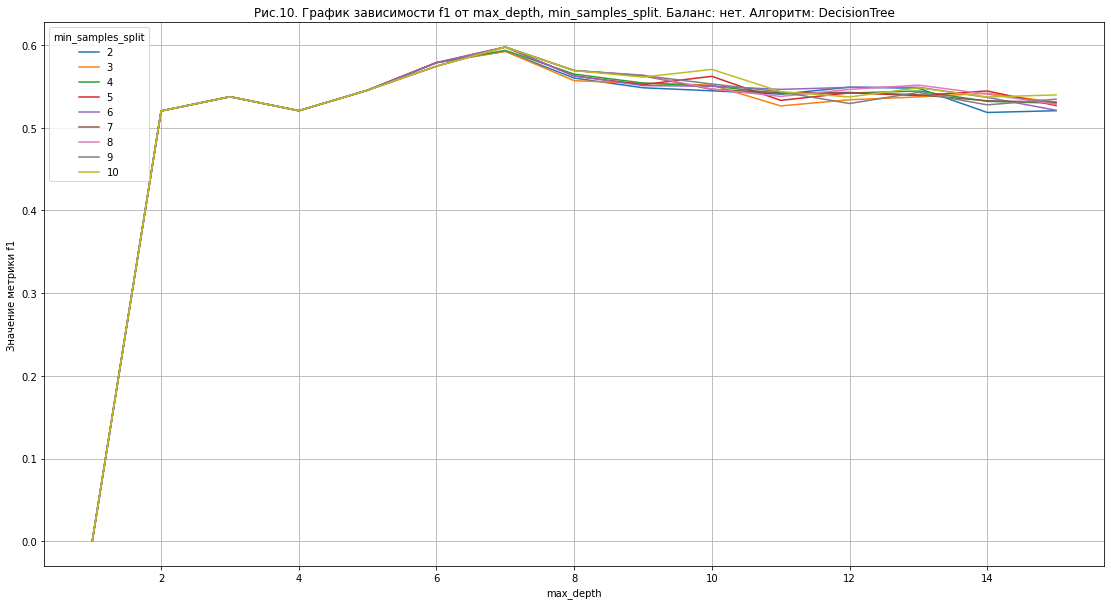

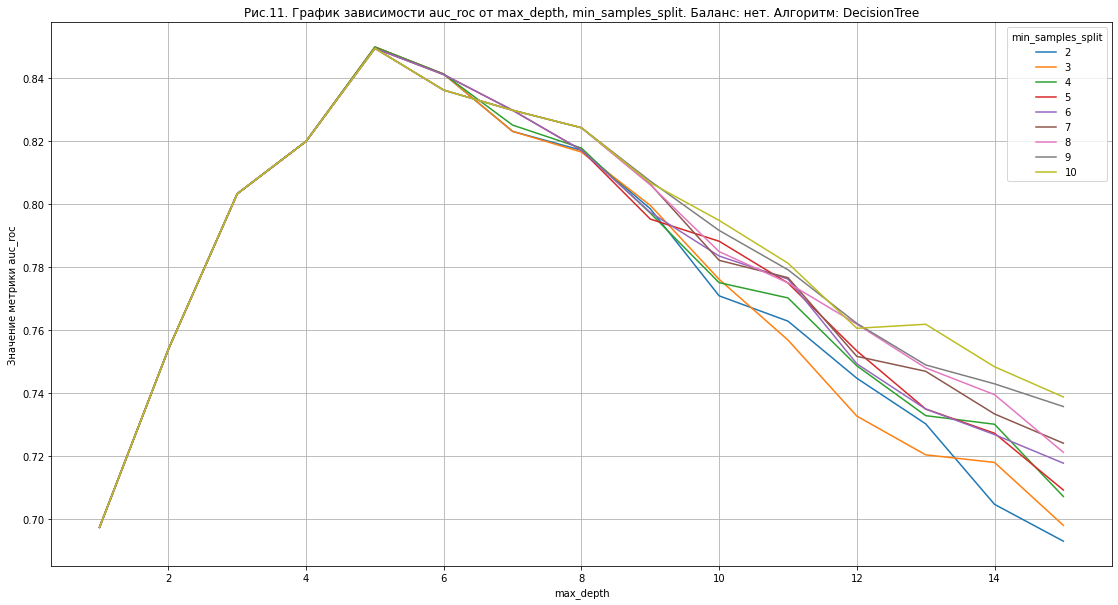

In [821]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 10, 'DecisionTree', 'нет', 'max_depth', 'min_samples_split')

Без учета дисбаланса классов наилучшая модель с использованием алгоритма дерева решений достигается при глубине дерева 7 и минимальном объеме выборки для разделения узла - 5. При максимальной глубине дерева больше 7 модель начинает переобучаться вне зависимости от значения параметра min_samples_split. До максимальной глубины дерева 5 значение метрики увеличивается ~ от 0.7 до ~0.85, при максимальной глубине дерева более 5 значение метрики AUC-ROC значительно снижается, при этом, чем меньше минимальный объем выборки для разделения, тем быстрее уменьшается AUC-ROC.

**Вывод по разделу:**
В текущем разделе было обучено три модели прогнозирования оттока клиентов "Бета-Банка" - на основе алгоритмов случайного леса, дерева решений и логистической регрессии. Модель на основе каждого из алгоритмов обучалась в два этапа:
- параметры алгоритма не изменялись (оставлены по умолчанию);
- подобраны наилучшие гиперпараметры алгоритмов.

Для дерева решений осуществлялся подбор максимальной глубины дерева и минимального объема выборки для разделения, для случайного леса - максимальной глубины дерева и количества деревьев, для логистической регрессии - максимального количества итераций.

Точность обученных моделей на валидационной выборке приведена в таблице:

In [822]:
final_table_part_1 = pd.DataFrame(final_table)
final_table_part_1

,model_name,algotyrhm,balance,f1,auc-roc
0,start_rf_model,RandomForest,No,0.596,0.858
1,best_rf_2,RandomForest,No,0.620,0.865
2,start_lr_model,LinearRegression,No,0.308,0.788
3,best_lr_2,LogisticRegression,No,0.308,0.788
4,start_dt_model,DecisionTree,No,0.515,0.697
5,best_dt_2,DecisionTree,No,0.598,0.830


*Примечание:*

 - *model_name - имя модели;*
 - *algorythm - используемый алгоритм обучения;*
 - *balance - метод учета дисбаланса классов (No - без учета);*
 - *f1 - значение метрики f1;*
 - *auc-roc - значение метрики AUC-ROC*

- наилучшую модель ***(на основании метрики f1)*** обеспечивает алгоритм случайного леса, при этом требуемое значение f1-меры было достигнуто уже на этапе проверки работы алгоритма при дефолтных параметрах (f1=0.596). Путем поиска наилучших гиперпараметров удалось улучшить модель до значения f1=0.620. Такой результат достигается при 30-ти деревьях и максимальной глубине дерева 14;

- второй по значению метрики f1 является модель на основе алгоритма дерева решений. При дефолтных настройках алгоритм позволяет достичь значения f1=0.515, что хуже требуемой точности (f1 должна быть не менее 0.59), однако после подбора гиперпараметров удалось улучшить метрику f1 до 0.598 (максимальная глубина дерева 7, минимальный объем выборки для разделения 5);

- наихудший результат показала модель на основе алгоритма логистической регрессии. Как на этапе оценки точности модели при гиперпараметрах по умолчанию, так и при подборе гиперпараметров (изменение максимального количества итераций от 100 до 200 с шагом 10) значение метрики f1 было постоянным и равным 0.308, что хуже требуемого практически в два раза;

- наибольшее значение метрики AUC-ROC наблюдается у моделей на основе алгоритма случайного леса: 0.858 при дефолтных гиперпараметрах и 0.865 после подбора наилучших гиперпараметров (улучшение составляет 0.007);

- наихудшее значение метрики AUC-ROC наблюдается у модели start_dt_model, обученной с помощью дерева решений при дефолтных гиперпараметров. После подбора гиперпараметров для дерева решений, наряду с f1, удалось улучшить и AUC-ROC: c 0.697 до 0.830;

- значение AUC-ROC для всех моделей на основе логистической регрессии постоянно и составляет 0.788.

# 4. Улучшение модели с помощью учета дисбаланса классов

В предыдущем этапе уже была получена модель прогноза оттока клиентов "Бета-банка", обеспечивающая требуемую точность предсказания. В соответствии с требованием задания на проект, построим несколько моделей с учетом дисбаланса классов.

Как и в предыдущем этапе, рассмотрим три алгоритма классификации: случайный лес, дерево решений и логистическую регрессию.
Для борьбы с дисбалансом классом воспользуемся методами взвешивания классов и увеличения выборки.

## 4.1 Улучшение модели с помощью взвешивания классов

Учтем соотношение классов в выборке с помощью гиперпараметра class_weight. Дополнительно осуществим поиск наилучших гиперпараметров при class_weight = 'balanced'.

### 4.1.1 Улучшение модели на основе алгоритма случайного леса

In [823]:
#сформируем словарь с гиперпараметрами
parameters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'class_weight':['balanced']}

In [824]:
#найдем наилучшую модель и выведем результаты на экран
best_balanced_rf_2, f1, auc_roc, metrics = training(features_train, target_train, features_valid, target_valid, parameters, 'rf')

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_balanced_rf_2', 'RandomForest', 'взвешивание', f1, auc_roc)

f1 0.65
auc_roc 0.871
Наилучшие параметры: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=40,
                       random_state=12345)


,n_estimators,f1,auc_roc,max_depth,class_weight
0,10,0.496938,0.800578,1,balanced
1,10,0.579624,0.822635,2,balanced
2,10,0.580407,0.836748,3,balanced
3,10,0.614271,0.855533,4,balanced
4,10,0.612078,0.858141,5,balanced
...,...,...,...,...,...
145,100,0.626566,0.866465,11,balanced
146,100,0.618799,0.865927,12,balanced
147,100,0.611797,0.865284,13,balanced
148,100,0.609309,0.861422,14,balanced


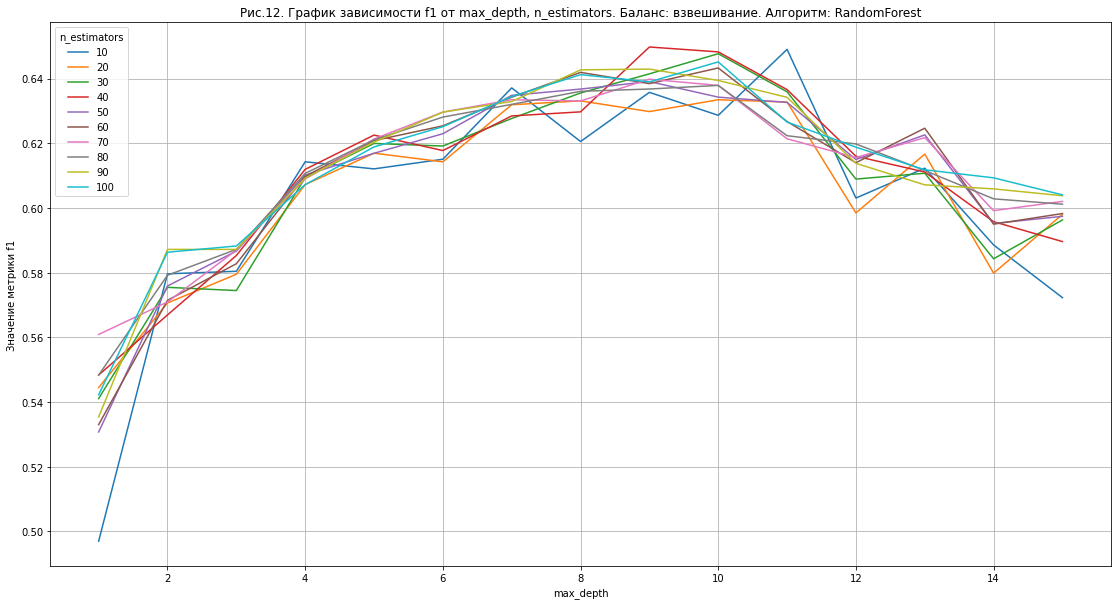

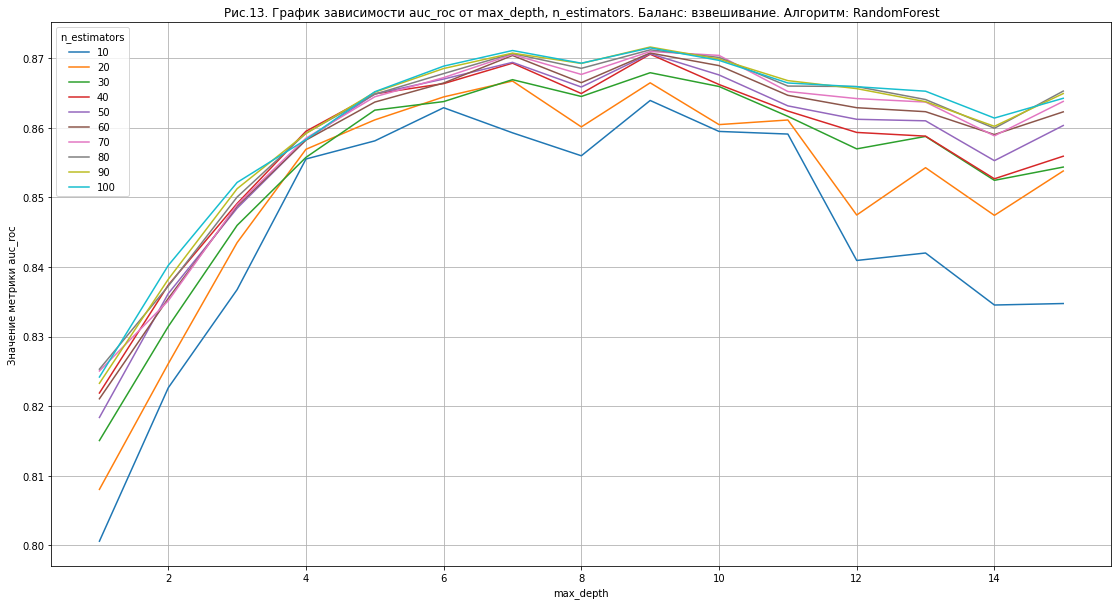

In [825]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 12, 'RandomForest', 'взвешивание', 'max_depth', 'n_estimators')

При учете дисбаланса классов модель на основе случайного леса удалось улучшить до значения метрики f1=0.650 (без учета дисбаланса классов наилучшая модель на основе случайного леса позволяет достичь f1=0.620). Гиперпараметры:
- class_weight = 'balanced';
- количество деревьев: 40;
- максимальная глубина дерева: 9.

При максимальной глубине дерева больше 10 модель начинает переобучаться, что вызывает снижение значений метрик f1 и AUC-ROC. Чем меньше количество деревьев, тем хуже качество модели.
Взвешивание классов привело к увеличению наилучшего количества деревьев с 30 до 40 и одновременному уменьшению глубины дерева с 14 до 9.

### 4.1.2 Улучшение модели на основе алгоритма логистической регрессии

In [826]:
#сформируем словарь с гиперпараметрами
parameters = {'max_iter':[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'class_weight':['balanced']}

In [827]:
#найдем наилучшую модель и выведем результаты на экран
best_balanced_lr_2, f1, auc_roc, metrics = training(features_train, target_train, features_valid, target_valid, parameters, 'lr')

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_balanced_lr_2', 'LogisticRegression', 'взвешивание', f1, auc_roc)

f1 0.53
auc_roc 0.794
Наилучшие параметры: LogisticRegression(class_weight='balanced', random_state=12345)


,max_iter,f1,auc_roc,class_weight
0,100,0.52993,0.793704,balanced
1,110,0.52993,0.793704,balanced
2,120,0.52993,0.793704,balanced
3,130,0.52993,0.793704,balanced
4,140,0.52993,0.793704,balanced
5,150,0.52993,0.793704,balanced
6,160,0.52993,0.793704,balanced
7,170,0.52993,0.793704,balanced
8,180,0.52993,0.793704,balanced
9,190,0.52993,0.793704,balanced


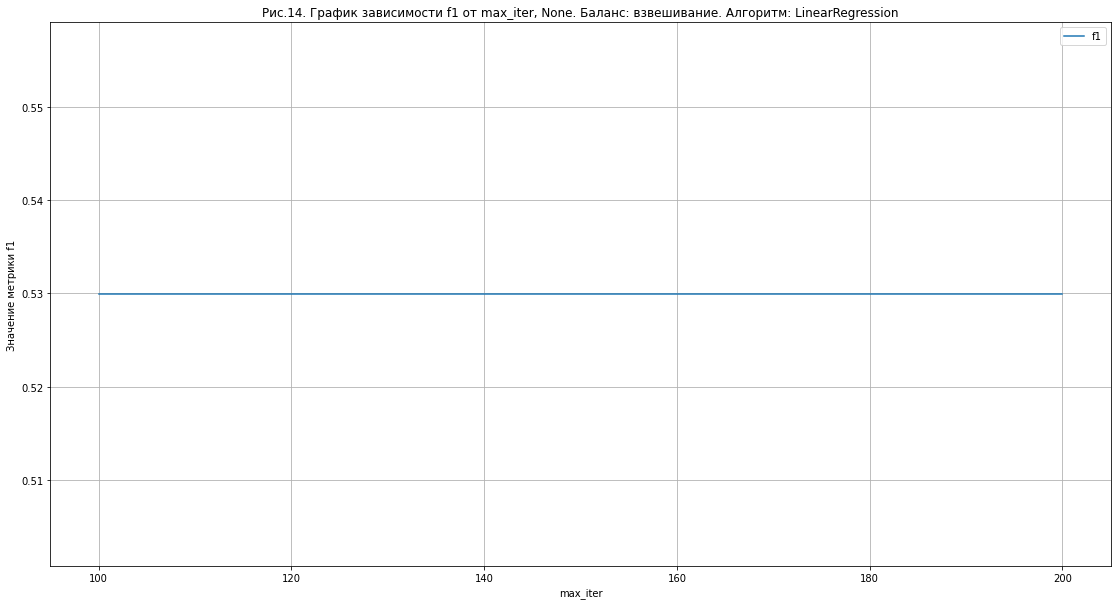

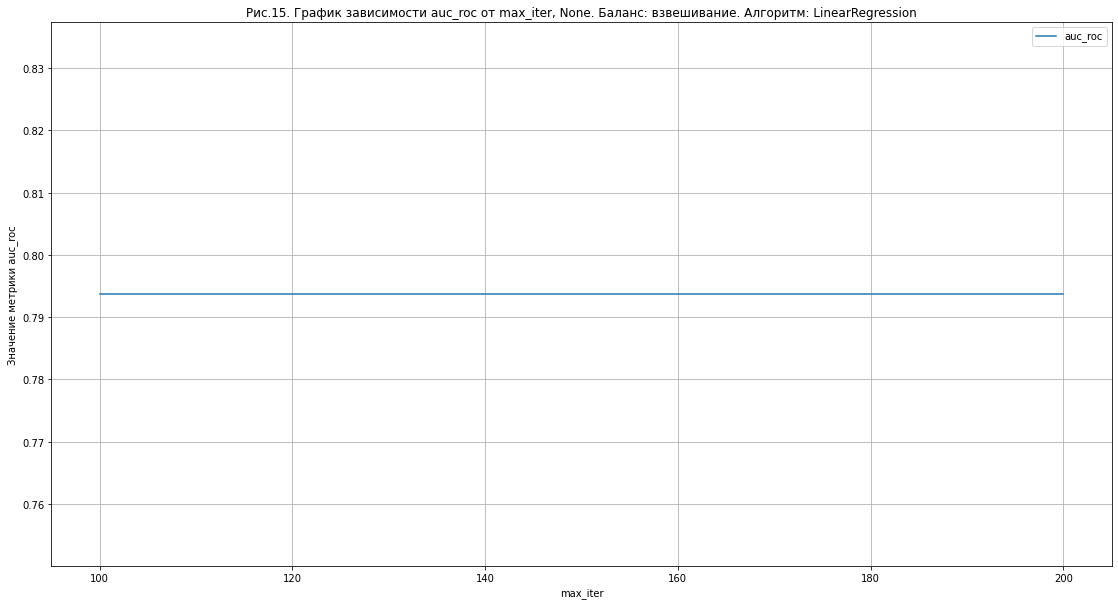

In [828]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 14, 'LinearRegression', 'взвешивание', 'max_iter', None)

При учете дисбаланса классов метрика f1 модели на основе логистической регрессии возрастает с 0.308 до 0.530, метрика AUC-ROC - с 0.788 до 0.794. Увеличение качества модели значительное, однако по-прежнему не удовлетворяет требуемой точности.
Количество итераций на точность модели также не повлияло.

### 4.1.3 Улучшение модели на основе алгоритма дерева решений

In [829]:
#сформируем словарь с гиперпараметрами
parameters = {'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'class_weight':['balanced']}

In [830]:
#найдем наилучшую модель и выведем результаты на экран
best_balanced_dt_2, f1, auc_roc, metrics = training(features_train, target_train, features_valid, target_valid, parameters, 'dt')

#запишем результаты в финальную табличку
lst_of_model_params = ['best_balanced_dt_2', 'RandomForest', 'взвешивание', f1, auc_roc]

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_balanced_dt_2', 'DecisionTree', 'взвешивание', f1, auc_roc)

f1 0.578
auc_roc 0.827
Наилучшие параметры: DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=4, random_state=12345)


,min_samples_split,f1,auc_roc,max_depth,class_weight
0,2,0.484653,0.701190,1,balanced
1,2,0.498011,0.747591,2,balanced
2,2,0.520710,0.788675,3,balanced
3,2,0.560932,0.822021,4,balanced
4,2,0.554649,0.841351,5,balanced
...,...,...,...,...,...
130,10,0.537374,0.766952,11,balanced
131,10,0.522523,0.755089,12,balanced
132,10,0.524924,0.748861,13,balanced
133,10,0.524390,0.750445,14,balanced


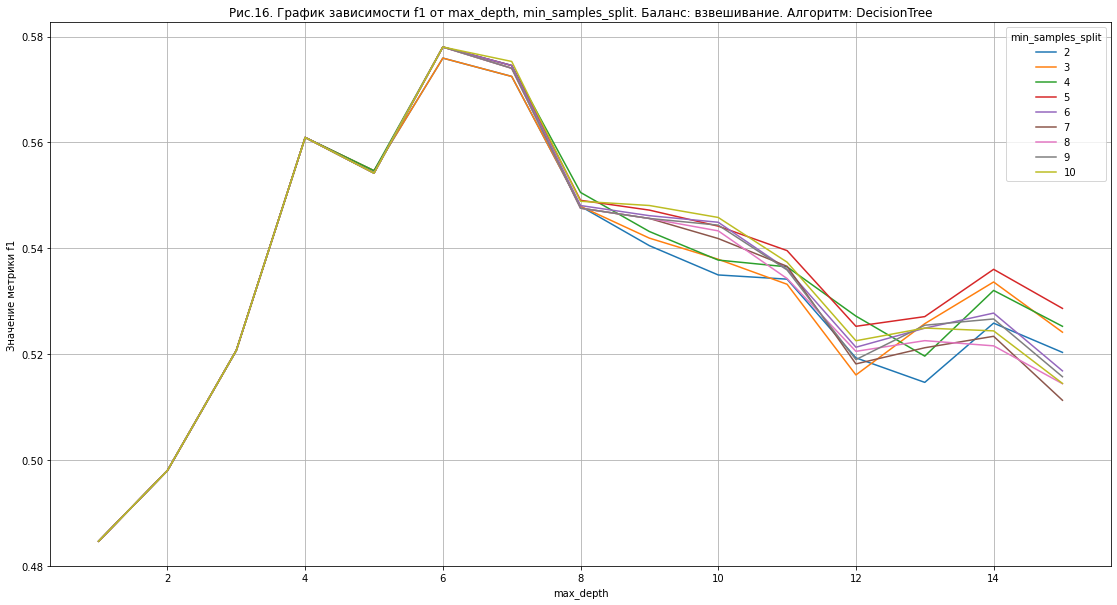

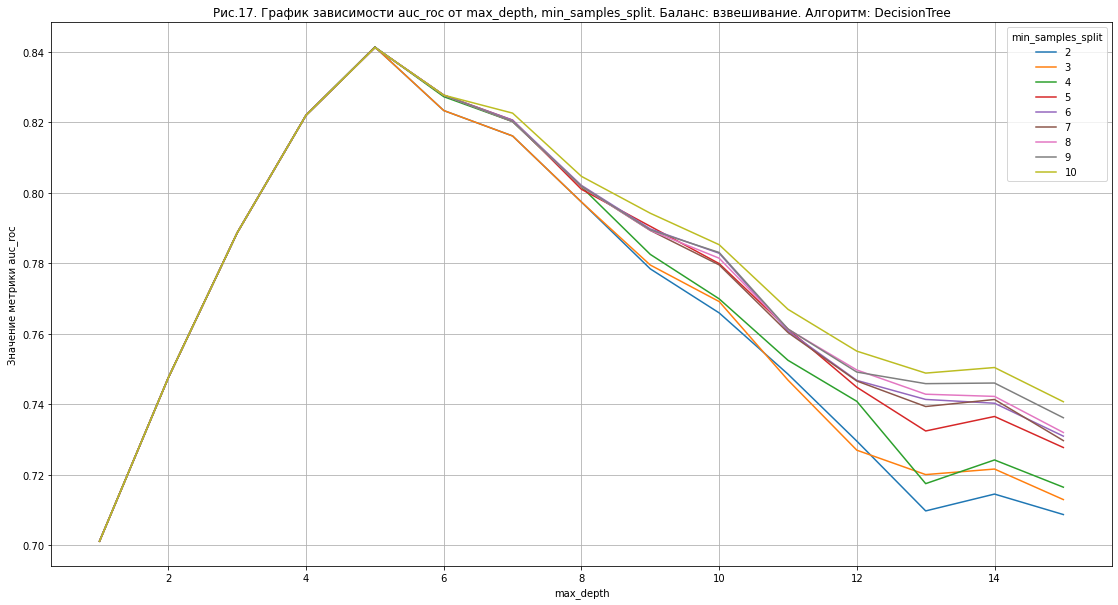

In [831]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 16, 'DecisionTree', 'взвешивание', 'max_depth', 'min_samples_split')

Взвешивание классов при обучении модели на основе дерева решений привело к снижению метрики f1 c 0.598 (без учета дисбаланса классов) до 0.578, что хуже требования задания на проект. Метрика AUC-ROC снизилась незначительно - с 0.830 до 0.827. При максимальной глубине дерева больше 6 модель начинает переобучаться. При максимальной глубине дерева больше 5 наблюдается снижение значения метрики AUC-ROC (чем меньше объем выборки для разделения, тем хуже модель).

## 4.2 Улучшение модели с помощью увеличения выборки

Учесть дисбаланс классов можно путем изменения объема выборки - как увеличения положительных объектов, так и уменьшения отрицательных. Так как в результате уменьшения количества отрицательных объектов можно потерять важные данные, воспользуемся техникой upsampling и увеличим количество положительных объектов.

In [832]:
#напишем функцию, увеличивающую количество положительных объектов
def upsample(features, target, repeat):
    
    #разделим объекты на положительные и отрицательные
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    #увеличим количество положительных объектов и объединим положительные объекты с отрицательными
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    #перемешаем датафрейм
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

На этапе [разбиения выборки](#3) было выявлено, что соотношение количества отрицательных и положительных объектов составляет 4:1. Исходя из этого, увеличим объем положительных объектов в 4 раза.

In [833]:
#увеличим количество положительных объектов
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [834]:
#проверим количество положительных и отрицательных объектов
print('Положительных объектов:', target_upsampled[target_upsampled==1].count())
print('Отрицательных объектов:', target_upsampled[target_upsampled==0].count())

Положительных объектов: 4888
Отрицательных объектов: 4778


Соотношение положительных и отрицательных объектов практически одинаковое (положительных больше на 2%). Перейдем к обучению.

<font color="green">✔️ Комментарий ревьювера   
Молодец, функция upsample сработала верно</font>


### 4.2.1 Улучшение модели на основе случайного леса

In [835]:
#сформируем словарь с гиперпараметрами
parameters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [836]:
best_upsampled_rf, f1, auc_roc, metrics = training(features_upsampled, target_upsampled, features_valid, target_valid, parameters, 'rf')

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_upsampled_rf', 'RandomForest', 'upsampling', f1, auc_roc)

f1 0.652
auc_roc 0.868
Наилучшие параметры: RandomForestClassifier(max_depth=10, n_estimators=30, random_state=12345)


,n_estimators,f1,auc_roc,max_depth
0,10,0.493573,0.792025,1
1,10,0.556918,0.829474,2
2,10,0.570435,0.841841,3
3,10,0.604331,0.849375,4
4,10,0.608534,0.860382,5
...,...,...,...,...
145,100,0.640643,0.868146,11
146,100,0.636364,0.867799,12
147,100,0.639225,0.866836,13
148,100,0.624079,0.864714,14


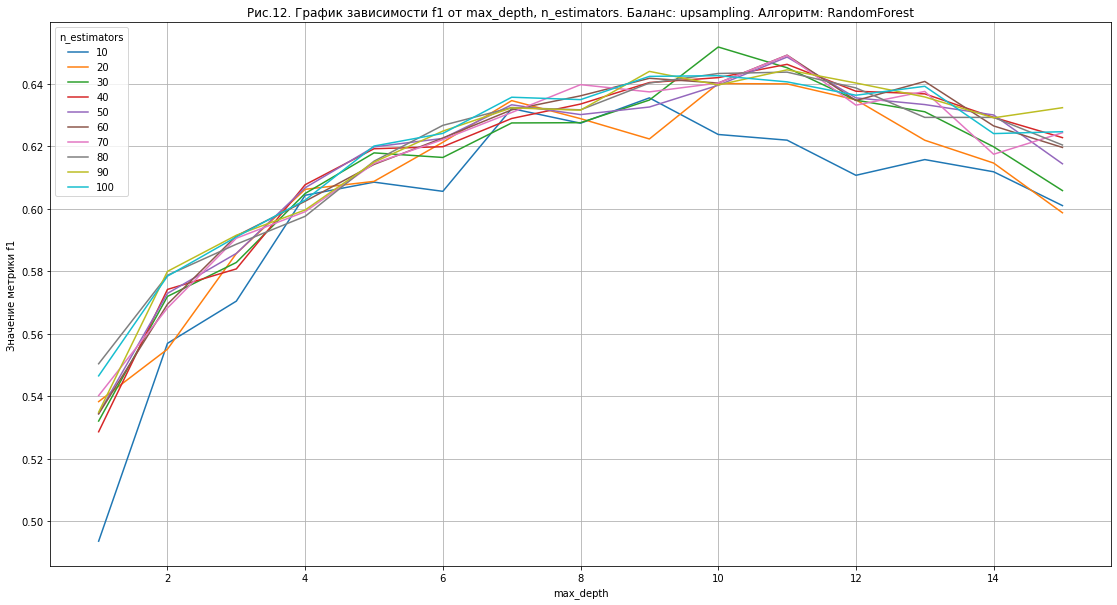

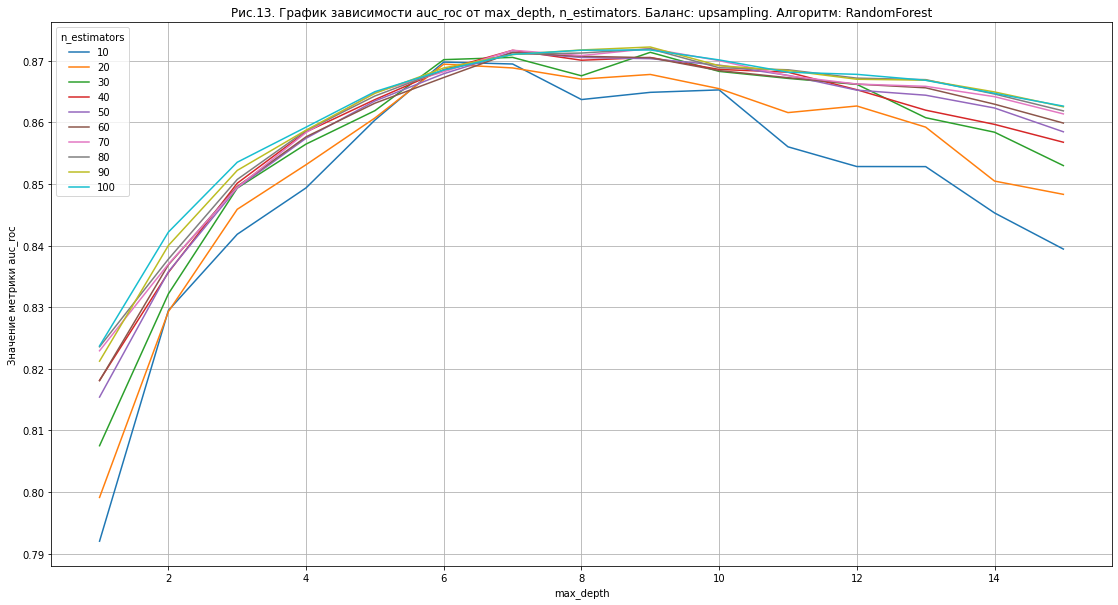

In [837]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 12, 'RandomForest', 'upsampling', 'max_depth', 'n_estimators')

При использовании техники upsampling максимальное значение метрики f1=0.652 достигается при максимальной глубине дерева 10 и количестве деревьев 30. Значение AUC-ROC при таких параметрах: 0.868. При глубине дерева больше 11 модель начинает переобучаться при любом рассмотренном количестве деревьев.

Опираясь на график на рис. 12, можно сделать вывод о том, что при максимальной глубине дерева 4 модель на основе случайного леса дает подходящее значение метрики f1 при любом рассмотренном количестве деревьев.

### 4.2.2 Улучшение модели на основе алгоритма логистической регрессии

In [838]:
#сформируем словарь с гиперпараметрами
parameters = {'max_iter':[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}

In [839]:
#найдем наилучшую модель и выведем результаты на экран
best_upsampled_lr, f1, auc_roc, metrics = training(features_upsampled, target_upsampled, features_valid, target_valid, parameters, 'lr')

#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_upsampled_lr', 'LogisticRegression', 'upsampling', f1, auc_roc)

f1 0.524
auc_roc 0.794
Наилучшие параметры: LogisticRegression(random_state=12345)


,max_iter,f1,auc_roc
0,100,0.523768,0.793759
1,110,0.523768,0.793759
2,120,0.523768,0.793759
3,130,0.523768,0.793759
4,140,0.523768,0.793759
5,150,0.523768,0.793759
6,160,0.523768,0.793759
7,170,0.523768,0.793759
8,180,0.523768,0.793759
9,190,0.523768,0.793759


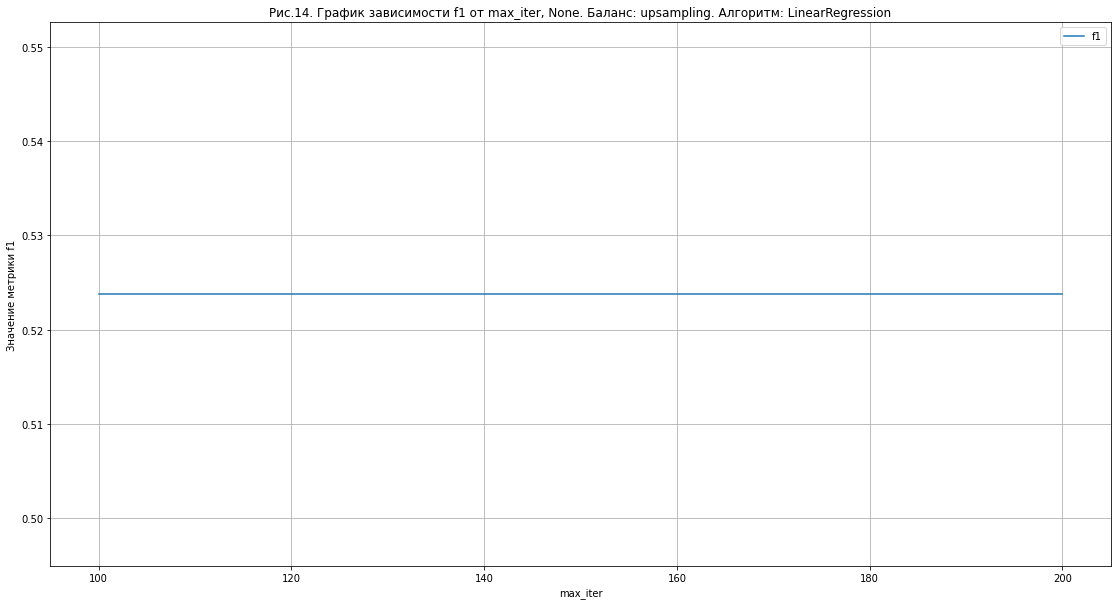

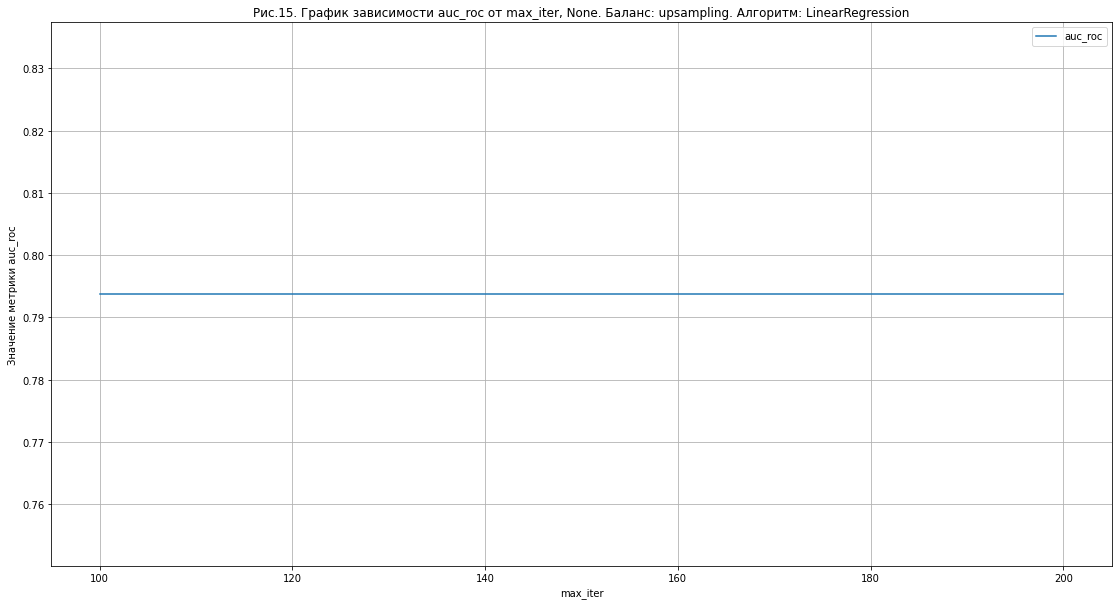

In [840]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 14, 'LinearRegression', 'upsampling', 'max_iter', None)

Точность модели на основе логистической регрессии при учете дисбаланса классов с помощью техники upsampling составляет f1=0.524, что меньше требуемого значения 0.59. AUC-ROC = 0.794. Как и в предыдущих случаях, изменение количества итераций на точность модели не влияет.

### 4.2.3 Улучшение модели на основе дерева решений

In [841]:
#сформируем словарь с гиперпараметрами
parameters = {'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [842]:
#найдем наилучшую модель и выведем результаты на экран
best_upsampled_dt, f1, auc_roc, metrics = training(features_upsampled, target_upsampled, features_valid, target_valid, parameters, 'dt')
    
#запишем результаты в табличку и выведем результаты на экран
fill_final_table('best_upsampled_dt', 'DecisionTree', 'upsampling', f1, auc_roc)

f1 0.578
auc_roc 0.828
Наилучшие параметры: DecisionTreeClassifier(max_depth=6, min_samples_split=10, random_state=12345)


Учет дисбаланса классов с помощью техники upsampling при обучении модели на основе дерева решений дал тот же результат, что и взвешивание классов. Значение метрики f1=0.578, что меньше требуемого значения.

,min_samples_split,f1,auc_roc,max_depth
0,2,0.484653,0.701190,1
1,2,0.498011,0.747591,2
2,2,0.498011,0.788675,3
3,2,0.560932,0.822021,4
4,2,0.554649,0.841351,5
...,...,...,...,...
130,10,0.535787,0.753713,11
131,10,0.518672,0.739634,12
132,10,0.520000,0.730749,13
133,10,0.519957,0.725302,14


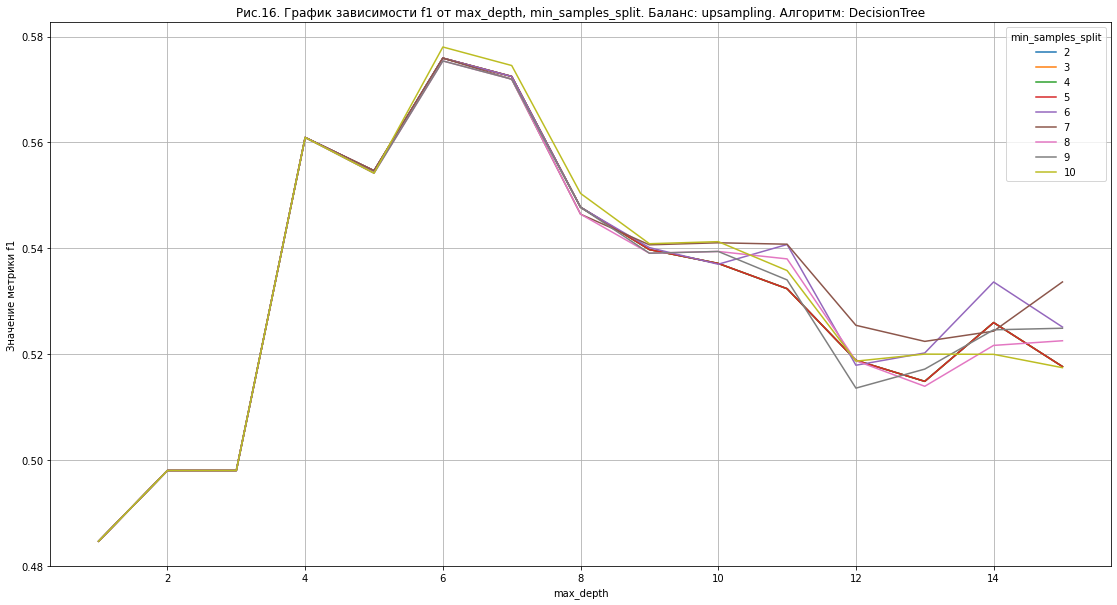

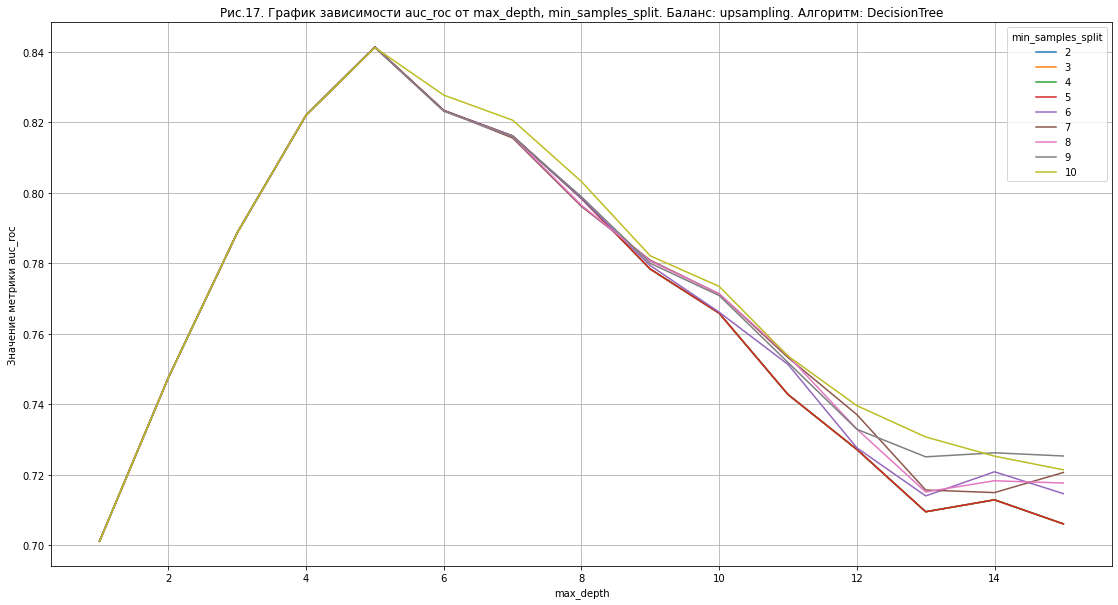

In [843]:
#построим графики зависимости метрик f1, auc-roc от рассмотренных гиперпараметров
plot_graphs(metrics, 16, 'DecisionTree', 'upsampling', 'max_depth', 'min_samples_split')

Учет дисбаланса классов с помощью техники upsampling при обучении модели на основе дерева решений дал тот же результат, что и взвешивание классов. Значение метрики f1=0.578, что меньше требуемого значения.

Как и в случае со взвешиванием классов, при глубине дерева больше 6 модель начинает переобучаться, при глубине больше 5 наблюдается снижение значения метрики AUC-ROC.

**Вывод:**
В текущем разделе было рассмотрено два способа учета дисбаланса классов: взвешивание и изменение объема выборки (увеличение числа положительных объектов). Каждый из способов был реализован с помощью трех алгоритмов: случайного леса, дерева решений и логистической регрессии. Были подобраны гиперпараметры, обеспечивающие наилучшую точность модели в совокупности с выбранным методом учета дисбаланса.

Точность моделей, полученная на валидационной выборке приведена в таблице:

In [844]:
final = pd.DataFrame(final_table)
final.sort_values(by='algotyrhm').reset_index(drop=True)

,model_name,algotyrhm,balance,f1,auc-roc
0,start_dt_model,DecisionTree,No,0.515,0.697
1,best_dt_2,DecisionTree,No,0.598,0.830
2,best_balanced_dt_2,DecisionTree,взвешивание,0.578,0.827
3,best_upsampled_dt,DecisionTree,upsampling,0.578,0.828
4,start_lr_model,LinearRegression,No,0.308,0.788
5,best_lr_2,LogisticRegression,No,0.308,0.788
6,best_balanced_lr_2,LogisticRegression,взвешивание,0.530,0.794
7,best_upsampled_lr,LogisticRegression,upsampling,0.524,0.794
8,start_rf_model,RandomForest,No,0.596,0.858
9,best_rf_2,RandomForest,No,0.620,0.865


*Примечание:*

 - *model_name - имя модели;*
 - *algorythm - используемый алгоритм обучения;*
 - *balance - метод учета дисбаланса классов;*
 - *f1 - значение метрики f1;*
 - *auc-roc - значение метрики AUC-ROC*

- для модели на основе случайного леса (RandomForest) учет дисбаланса классов привел к увеличению значения метрики f1 со значения 0.620 (без учета дисбаланса) до 0.650 (взвешивание) и 0.652 (upsampling). На фоне увеличения метрики f1 при борьбе с дисбалансом увеличивается и метрика AUC-ROC;
- для модели на основе дерева решений (DecisionTree) оба рассмотренных способа учета дисбаланса классов показали одинаковый результат, снизив значение f1 с 0.598 (без учета дисбаланса) до 0.578. Общее изменение метрики составило -0.02, однако такое изменение оказалось критичным - модель с учетом дисбаланса не удовлетворяет требованиям задания на проект. Снизилось также и значение метрики AUC-ROC - при взвешивании изменение составляет 0.003 (по сравнению  с показателями модели best_dt_2), при увеличении выборки - 0.002;
- модель на основе логистической регрессии (logisticRegression) удалось значительно улучшить за счет учета дисбаланса классов, достигнув значения метрики f1=0.530 и f1=0.524 для техники взвешивания и upsampling соответственно. Однако, несмотря на существенный рост качества, модель по-прежнему не является достаточно точной. Значение AUC-ROC увеличилось незначительно - на 0.006;
- изменение метрики AUC-ROC после учета дисбаланса не превышает +0.01.

Наилучшее значение метрики f1=0.651 среди всех обученных моделей наблюдается для модели best_upsampled_rf, реализованной с помощью дерева решений и учитывающей дисбаланс классов с помощью техники upsampling. Максимальная глубина дерева указанной модели: 10, максимальное количество деревьев: 30. Значение AUC-ROC на валидационной выборке: 0.868. Выберем модель best_upsampled_rf как лучшую и проверим ее качество на тестовой выборке.

# 5. Проверка качества модели на тестовой выборке

В текущем разделе проверим на тестовой выборке качество наилучшей модели best_upsampled_rf, выбранной на предыдущем этапе.

In [845]:
#сделаем прогноз
predictions = best_upsampled_rf.predict(features_test)

#рассчитаем долю верных ответов
result = accuracy_score(target_test, predictions)

#рассчитаем значение метрики f1
f1 = f1_score(target_test, predictions)

print('Доля правильных ответов:', result)
print('f1-мера:', f1)

Доля правильных ответов: 0.8165
f1-мера: 0.5989071038251366


Выбранная наилучшая модель прогноза оттока клиентов "Бета-банка" на тестовой выборке предсказала верно 82% ответов. Значение метрики f1 составляет 0.598, что хуже, чем на валидационной выборке, однако удовлетворяет требованиям задания на проект.

Объединим обучающую и валидационную выборку и переобучим модель best_upsampled_rf, после чего проверим качество переобученной модели на тестовой выборке.

In [846]:
#объединим тренировочную и валидационную выборки:
features_train_2 = pd.concat([features_train]+[features_valid])
target_train_2 = pd.concat([target_train]+[target_valid])

#проверим размерности
print(features_train_2.shape)
print(target_train_2.shape)

(8000, 11)
(8000,)


In [847]:
#рассчитаем процент положительных и отрицательных объектов (должно быть, как в исходном датафрейме)
target_train_2.value_counts(normalize=True)

0    0.79625
1    0.20375
Name: exited, dtype: float64

In [848]:
#увеличим количество положительных объектов
features_upsampled_2, target_upsampled_2 = upsample(features_train_2, target_train_2, 4)

#проверим количество положительных и отрицательных объектов
target_upsampled_2.value_counts(normalize=True)

1    0.505818
0    0.494182
Name: exited, dtype: float64

In [849]:
#переобучим модель, используя наилучшие гиперпараметры, полученные в разделе 4.2.1
best_upsampled_rf_2 = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10) 
best_upsampled_rf_2.fit(features_upsampled_2, target_upsampled_2)

#сделаем прогноз с помощью новой модели
predictions = best_upsampled_rf_2.predict(features_test)

#рассчитаем долю верных ответов
result = accuracy_score(target_test, predictions)

#рассчитаем значение метрики f1
f1 = f1_score(target_test, predictions)

print('Доля правильных ответов:', result)
print('f1-мера:', f1)


Доля правильных ответов: 0.8155
f1-мера: 0.5984766050054406


Новая модель, обученная на объединенной обучающей и валидационной выборке, показала на тестовой выборке результат незначительно хуже, чем модель best_upsampled_rf. Примем модель best_upsampled_rf в качестве итоговой.

<font color="green">✔️ Комментарий ревьювера   
Молодец</font>

# 5. Проверка моделей на вменяемость

Для оценки адекватности модели воспользуемся двумя способами:
- сравним модель с наилучшей константной моделью;
- сравним модель с наилучше случайной моделью (рассчитаем параметр AUC-ROC).

**Сравним модель с константной моделью:**

Так как 80% объектов в тестовой выборке принадлежат к отрицательному классу (обусловлено соотношением классов в исходной выборке и использованием параметра stratify при ее разбиении), то наилучшая константная модель будет предсказывать только нули. В таком случае точность (долю правильных ответов) такой модели можно рассчитать следующим образом:

In [850]:
print('Точность константной модели:', 1-target_test.mean())

Точность константной модели: 0.7965


**Сравним модель со случайной моделью:**

In [851]:
probabilities_test = best_upsampled_rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

#рассчитаем параметр AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8497295446447989

Точность наилучшей модели best_upsampled_rf, реализованной с помощью алгоритма случайного леса, превышает точность константной модели на 1.02% (удовлетворительно, так как процент правильных ответов константной модели довольно высок).

Значение метрики AUC_ROC больше, чем у случайной модели, на 0.35 (но на 0.018 меньше, чем на валидационной выборке).

Модель вменяема.

# 5. Общий вывод

В рамках создания модели прогноза оттока клиентов "Бета-банка" реализованы следующие этапы:
- выполнена предобработка данных для корректного обучения модели, а именно:
    - выполнен поиск аномальных значений и выбросов;
    - осуществлено заполнение пропусков признака `tenure` - пропуски заменены медианным значением, характерным для возраста клиента;
    - выполнен поиск явных и неявных дубликатов;
    - выполнена корректировка  типов данных;
    - выполнена кодировка категориальных признаков;
    - выполнено разбиение исходных данных на обучающую, валидационную и тестовую выборки;
    - путем стандартизации численные признаки приведены к одному масштабу;

- исследован баланс классов: в исходном датафрейме соотношение пользующихся услугами банка клиентов и клиентов, отказавшихся от услуг банка, составляет 4:1;
- на основе алгоритмов случайного леса, дерева решений и логистической регрессии было обучено три модели без учета дисбаланса классов. В процессе обучения с помощью цикла для каждого алгоритма были получены наилучшие гиперпараметры. Оценка качества моделей проводилась на основании значения метрики f1. Дополнительно рассчитано значение метрики AUC-ROC для каждой модели. Качество моделей, не учитывающих дисбаланс классов, полученное на валидационной выборке для каждого из алгоритмов приведено в таблице:

In [852]:
final_table_part_1

,model_name,algotyrhm,balance,f1,auc-roc
0,start_rf_model,RandomForest,No,0.596,0.858
1,best_rf_2,RandomForest,No,0.620,0.865
2,start_lr_model,LinearRegression,No,0.308,0.788
3,best_lr_2,LogisticRegression,No,0.308,0.788
4,start_dt_model,DecisionTree,No,0.515,0.697
5,best_dt_2,DecisionTree,No,0.598,0.830


- на основе алгоритмов случайного леса, дерева решений и логистической регрессии было обучено шесть моделей, учитывающих дисбаланс классов  с помощью взвешивания или с помощью техники upsampling. Качество моделей, полученное на валидационной выборке, приведено в таблице:

In [853]:
final_table_part_2 = pd.DataFrame(final_table)
final_table_part_2 = final_table_part_2[final_table_part_2['balance']!='No']
final_table_part_2

,model_name,algotyrhm,balance,f1,auc-roc
6,best_balanced_rf_2,RandomForest,взвешивание,0.650,0.871
7,best_balanced_lr_2,LogisticRegression,взвешивание,0.530,0.794
8,best_balanced_dt_2,DecisionTree,взвешивание,0.578,0.827
9,best_upsampled_rf,RandomForest,upsampling,0.652,0.868
10,best_upsampled_lr,LogisticRegression,upsampling,0.524,0.794
11,best_upsampled_dt,DecisionTree,upsampling,0.578,0.828


В результе анализа качества моделей на валидационной выборке наилучшей моделью была выбрана модель **best_upsampled_rf** на основе алгоритма случайного леса с количеством деревьев 30, глубине дерева 10, обученная на тренироваочном датасете с помощью техники увеличения выборки. Значение метрики **f1** выбранной модели на тестовой выборке составило **0.598**, что удовлетворяет требованиям проекта. Значение метрики **AUC-ROC** выбранной модели на тестовой выборке составило **0.850**.

В рамках оценки адекватности модели была выполнена ее проверка с наилучшей константной моделью и случайной моделью. Доля правильных ответов модели прогноза оттока клиентов "Бета-банка" на тестовой выборке превышает точность константной модели на 1.02%, значение AUC_ROC больше, чем у случайной модели на 0.35. Модель вменяема.

Абсолютное изменение значения метрики AUC-ROC до и после учета дисбаланса не превышает 0.01 (для сравнения взяты наилучшие модели для каждого алгоритма до и после учета дисбаланса).

<div align="center"><b> КОТИК ДЛЯ РЕВЬЮЕРА :) </b></div> 
<img src="https://mysekret.ru/wp-content/uploads/2019/09/mycollages-1-30.jpg" align=center width=500, heigth=50>